In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import tempfile
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
dataset_path='dataset/'

# 选择要识别的属性
attr='Male' 

# 读取数据属性表
df_data_attr=pd.read_csv('list_attr_celeba.csv')
print('属性表')
for i, j in enumerate(df_data_attr.columns):
    print(i, j)
df_data_attr.head()

属性表
0 image_id
1 5_o_Clock_Shadow
2 Arched_Eyebrows
3 Attractive
4 Bags_Under_Eyes
5 Bald
6 Bangs
7 Big_Lips
8 Big_Nose
9 Black_Hair
10 Blond_Hair
11 Blurry
12 Brown_Hair
13 Bushy_Eyebrows
14 Chubby
15 Double_Chin
16 Eyeglasses
17 Goatee
18 Gray_Hair
19 Heavy_Makeup
20 High_Cheekbones
21 Male
22 Mouth_Slightly_Open
23 Mustache
24 Narrow_Eyes
25 No_Beard
26 Oval_Face
27 Pale_Skin
28 Pointy_Nose
29 Receding_Hairline
30 Rosy_Cheeks
31 Sideburns
32 Smiling
33 Straight_Hair
34 Wavy_Hair
35 Wearing_Earrings
36 Wearing_Hat
37 Wearing_Lipstick
38 Wearing_Necklace
39 Wearing_Necktie
40 Young


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


20000
img shape: h: 218, w: 178, c: 3
new shape: h: 128, w: 104
(128, 104)


Text(0.5, 1.0, 'Resized Gray Img')

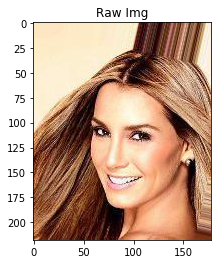

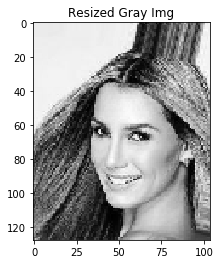

In [3]:
# 读取图片
img_list=os.listdir(dataset_path)

# print(img_list[:3])

dataset_len=20000

img_list=img_list[:dataset_len]
print(len(img_list))

im1=Image.open(dataset_path+img_list[0])
h,w,c=np.shape(im1)
print('img shape: h: %d, w: %d, c: %d'%(h,w,c))
plt.figure(1)
plt.imshow(im1)
plt.title("Raw Img")

# resize to new h,w
img_h=int(128)
img_w=int((w/h)*img_h)
print('new shape: h: %d, w: %d'%(img_h,img_w))

img = im1.convert("L")
img = img.resize((img_w,img_h))
print(np.shape(img))
plt.figure(2)
plt.imshow(img, cmap = plt.cm.gray)
plt.title("Resized Gray Img")

In [4]:
# 读取数据集图片列表

celeb_images = np.zeros((len(img_list), img_h*img_w))
celeb_labels = []
for idx, filename in enumerate(img_list):
    # 读取图片
    img_file = dataset_path + filename
    img = Image.open(img_file)
    img = img.convert("L")
    img = img.resize((img_w , img_h))
    # plt.imshow(img)
    img = np.asarray(img, dtype=np.float32)
    celeb_images[idx, :] = img.flatten()
    # print(celeb_images[idx, :])
    # 读取标签
    attr_value=df_data_attr.loc[idx,attr]
    # 读取墨镜对应标签，并使用 one-hot 编码
    if int(attr_value) == 1:
        labels = [0, 1]
    else:
        labels = [1, 0]
    celeb_labels.append(labels)

celeb_images = np.asarray(celeb_images, dtype=np.float32)
print(np.shape(celeb_images))
celeb_labels = np.asarray(celeb_labels, dtype=np.float32)

print('attr: %s=1 has: %g'%(attr,np.sum(celeb_labels[:,1])))
print('attr: %s!=1 has: %g'%(attr,np.sum(celeb_labels[:,0])))

celeb_images = 1.0 - celeb_images / 255.0

# shuffle the data
randomize = np.arange(len(celeb_images))
np.random.shuffle(randomize)
celeb_images_random = celeb_images[randomize]
celeb_labels_random = celeb_labels[randomize]

# divide the data into 2 sets: training and testing
train_images = celeb_images_random[:int(len(celeb_images_random) * 0.9)]
train_labels = celeb_labels_random[:int(len(celeb_labels_random) * 0.9)]

test_images = celeb_images_random[int(len(celeb_images_random) * 0.9):]
test_labels = celeb_labels_random[int(len(celeb_labels_random) * 0.9):]

(20000, 13312)
attr: Male=1 has: 8431
attr: Male!=1 has: 11569


In [5]:
def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [6]:
def model(x):

    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, img_h, img_w, 1])

    # First convolutional layer - maps one grayscale image to 32 feature maps.
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    # Pooling layer - downsamples by 2X.
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1)

    # Second convolutional layer -- maps 32 feature maps to 64.
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    # Second pooling layer.
    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv2)

    # Third convolutional layer -- maps 64 feature maps to 128.
    with tf.name_scope('conv3'):
        W_conv3 = weight_variable([5, 5, 64, 128])
        b_conv3 = bias_variable([128])
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)

    # Third pooling layer.
    with tf.name_scope('pool3'):
        h_pool3 = max_pool_2x2(h_conv3)
        print(h_pool3.get_shape())
        _,pl3_h,pl3_w,pl3_c=h_pool3.get_shape()
        print(pl3_h,pl3_w,pl3_c)


    with tf.name_scope('fc1'):
        W_fc1 = weight_variable([int(pl3_h*pl3_w*pl3_c), 1024])
        b_fc1 = bias_variable([1024])

        h_pool3_flat = tf.reshape(h_pool3, [-1, int(pl3_h*pl3_w*pl3_c)])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

    # Dropout - controls the complexity of the model, prevents co-adaptation of
    # features.
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Map the 1024 features to 2 classes, one for each digit
    with tf.name_scope('fc2'):
        W_fc2 = weight_variable([1024, 2])
        b_fc2 = bias_variable([2])

        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    return y_conv, keep_prob

In [7]:
# Create the model
x = tf.placeholder(tf.float32, [None, img_h*img_w])

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 2])

# Build the graph for the deep net
y_conv, keep_prob = model(x)

print(y_conv.get_shape())
print(y_.get_shape())
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_,
                                                            logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)
# tf.summary.scalar('cross_entropy', cross_entropy)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
# tf.summary.scalar('accuracy', accuracy)


# merged = tf.summary.merge_all()
# train_writer = tf.summary.FileWriter('../graphs/train1',
#                                     sess.graph)
# test_writer = tf.summary.FileWriter('../graphs/test1')

graph_location = tempfile.mkdtemp()
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
batch_size = 100
training_epochs = 20
total_batch = int(train_images.shape[0] / batch_size)
print(total_batch)
train_loss = []
train_acc=[]
iteration = []
for epoch in range(training_epochs):
    for i in range(total_batch):
        batch_x, batch_y = train_images[i * batch_size: (i + 1) * batch_size], train_labels[
                                                                               i * batch_size: (i + 1) * batch_size]
        if i % 5 == 0:
            loss,train_accuracy = sess.run([cross_entropy,accuracy], feed_dict={x: batch_x, y_: batch_y, keep_prob: 0.5})
            print('epoch %d: training loss: %g, training accuracy %g' % (epoch,loss,train_accuracy))
            train_loss.append(loss)
            train_acc.append(train_accuracy)
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y, keep_prob: 0.5})

Instructions for updating:
Colocations handled automatically by placer.
(?, 16, 13, 128)
16 13 128
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 2)
(?, 2)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Saving graph to: C:\Users\Haggi\AppData\Local\Temp\tmpwkpsihhu
180
epoch 0: training loss: 20.6326, training accuracy 0.5
epoch 0: training loss: 23.0873, training accuracy 0.55
epoch 0: training loss: 19.7674, training accuracy 0.49
epoch 0: training loss: 13.4917, training accuracy 0.57
epoch 0: training loss: 10.0134, training accuracy 0.64
epoch 0: training loss: 5.59774, training accuracy 0.7
epoch 0: training loss: 5.9322, training accuracy 0.63
epoch 0: training loss: 5.10873, training accuracy 0.66
epoch 0: training loss: 4.44456, training accuracy 0.69
epoch 0: trai

epoch 3: training loss: 0.367284, training accuracy 0.84
epoch 3: training loss: 0.336108, training accuracy 0.85
epoch 3: training loss: 0.318962, training accuracy 0.86
epoch 3: training loss: 0.40618, training accuracy 0.81
epoch 3: training loss: 0.344364, training accuracy 0.87
epoch 3: training loss: 0.387033, training accuracy 0.85
epoch 3: training loss: 0.369965, training accuracy 0.83
epoch 3: training loss: 0.419514, training accuracy 0.8
epoch 3: training loss: 0.34256, training accuracy 0.86
epoch 3: training loss: 0.243089, training accuracy 0.9
epoch 3: training loss: 0.4381, training accuracy 0.84
epoch 3: training loss: 0.366757, training accuracy 0.83
epoch 3: training loss: 0.311038, training accuracy 0.86
epoch 3: training loss: 0.443974, training accuracy 0.82
epoch 3: training loss: 0.241067, training accuracy 0.88
epoch 3: training loss: 0.26466, training accuracy 0.87
epoch 3: training loss: 0.228415, training accuracy 0.89
epoch 3: training loss: 0.395442, trai

epoch 7: training loss: 0.21214, training accuracy 0.93
epoch 7: training loss: 0.21151, training accuracy 0.91
epoch 7: training loss: 0.205988, training accuracy 0.92
epoch 7: training loss: 0.266965, training accuracy 0.86
epoch 7: training loss: 0.229588, training accuracy 0.9
epoch 7: training loss: 0.18952, training accuracy 0.94
epoch 7: training loss: 0.305602, training accuracy 0.88
epoch 7: training loss: 0.204253, training accuracy 0.93
epoch 7: training loss: 0.142077, training accuracy 0.94
epoch 7: training loss: 0.219604, training accuracy 0.91
epoch 7: training loss: 0.238709, training accuracy 0.87
epoch 7: training loss: 0.181409, training accuracy 0.92
epoch 7: training loss: 0.263787, training accuracy 0.87
epoch 7: training loss: 0.173866, training accuracy 0.92
epoch 7: training loss: 0.252616, training accuracy 0.9
epoch 7: training loss: 0.215244, training accuracy 0.91
epoch 7: training loss: 0.293113, training accuracy 0.89
epoch 8: training loss: 0.253991, tr

epoch 11: training loss: 0.165984, training accuracy 0.92
epoch 11: training loss: 0.161198, training accuracy 0.95
epoch 11: training loss: 0.168746, training accuracy 0.94
epoch 11: training loss: 0.25661, training accuracy 0.9
epoch 11: training loss: 0.19903, training accuracy 0.9
epoch 11: training loss: 0.165492, training accuracy 0.93
epoch 11: training loss: 0.208678, training accuracy 0.93
epoch 11: training loss: 0.158136, training accuracy 0.95
epoch 11: training loss: 0.1032, training accuracy 0.96
epoch 11: training loss: 0.124283, training accuracy 0.95
epoch 11: training loss: 0.111366, training accuracy 0.95
epoch 11: training loss: 0.157612, training accuracy 0.92
epoch 11: training loss: 0.172166, training accuracy 0.94
epoch 11: training loss: 0.139696, training accuracy 0.95
epoch 11: training loss: 0.132612, training accuracy 0.94
epoch 11: training loss: 0.112724, training accuracy 0.95
epoch 11: training loss: 0.219164, training accuracy 0.88
epoch 12: training l

epoch 15: training loss: 0.131286, training accuracy 0.95
epoch 15: training loss: 0.0916401, training accuracy 0.96
epoch 15: training loss: 0.0940387, training accuracy 0.96
epoch 15: training loss: 0.131883, training accuracy 0.94
epoch 15: training loss: 0.129583, training accuracy 0.96
epoch 15: training loss: 0.140709, training accuracy 0.94
epoch 15: training loss: 0.182137, training accuracy 0.92
epoch 15: training loss: 0.096118, training accuracy 0.98
epoch 15: training loss: 0.133128, training accuracy 0.94
epoch 15: training loss: 0.129157, training accuracy 0.95
epoch 15: training loss: 0.113416, training accuracy 0.95
epoch 15: training loss: 0.14412, training accuracy 0.92
epoch 15: training loss: 0.158971, training accuracy 0.94
epoch 15: training loss: 0.174164, training accuracy 0.92
epoch 15: training loss: 0.123465, training accuracy 0.96
epoch 15: training loss: 0.124646, training accuracy 0.94
epoch 15: training loss: 0.124551, training accuracy 0.95
epoch 15: tra

epoch 19: training loss: 0.142468, training accuracy 0.91
epoch 19: training loss: 0.0909183, training accuracy 0.95
epoch 19: training loss: 0.0664554, training accuracy 0.97
epoch 19: training loss: 0.0607079, training accuracy 0.99
epoch 19: training loss: 0.0740054, training accuracy 0.98
epoch 19: training loss: 0.116227, training accuracy 0.94
epoch 19: training loss: 0.048194, training accuracy 0.98
epoch 19: training loss: 0.129452, training accuracy 0.95
epoch 19: training loss: 0.121134, training accuracy 0.94
epoch 19: training loss: 0.11606, training accuracy 0.97
epoch 19: training loss: 0.0876874, training accuracy 0.97
epoch 19: training loss: 0.107808, training accuracy 0.96
epoch 19: training loss: 0.054261, training accuracy 0.95
epoch 19: training loss: 0.0744624, training accuracy 0.98
epoch 19: training loss: 0.0750089, training accuracy 0.95
epoch 19: training loss: 0.0879344, training accuracy 0.95
epoch 19: training loss: 0.0857409, training accuracy 0.97
epoch 

Text(0.5, 0, '(20 steps/epoch)%5, 20 epochs')

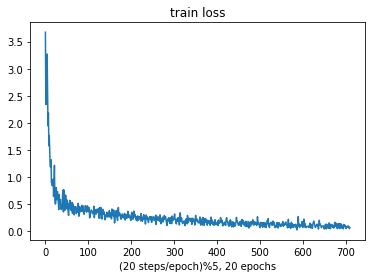

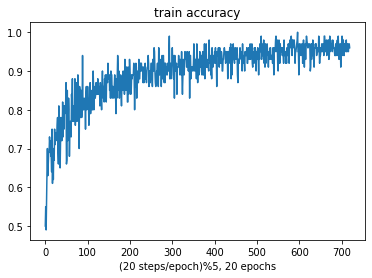

In [10]:
xlabel_name='('+str(total_batch)+' steps/epoch)%5, '+str(training_epochs)+' epochs'

# plt.subplot(1,2,1)
plt.figure(1)
plt.plot(train_loss[10:])
plt.xlabel(xlabel_name)
plt.title('train loss')

# plt.subplot(1,2,2)
plt.figure(2)
plt.plot(train_acc)
plt.title('train accuracy')
plt.xlabel(xlabel_name)

In [9]:
# test
test_acc=[]
total_batch = int(test_images.shape[0] / batch_size)
for i in range(total_batch):
    batch_test_x, batch_test_y = test_images[i * batch_size: (i + 1) * batch_size], test_labels[
                                                            i * batch_size: (i + 1) * batch_size]
    acc=sess.run(accuracy, feed_dict={x: batch_test_x, y_: batch_test_y, keep_prob: 1.0})
    test_acc.append(acc)
print("test accuracy: %g"%np.mean(test_acc))

test accuracy: 0.931
